# Project_3: Finding “Good Value” Airbnb Neighborhoods in New York City



## Project_3 Prompt

**Dataset(s) to be used:**  
(https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

**Analysis question:**  
How do Airbnb prices differ across NYC boroughs and room types, and which neighborhoods offer the best “value for money,” defined as listings that are relatively cheap but still attract many reviews?

**Columns that will (likely) be used:**
- `neighbourhood_group` – borough (Manhattan, Brooklyn, etc.)
- `neighbourhood` – neighborhood name
- `room_type` – Entire home/apt, Private room, Shared room
- `price` – nightly price in USD
- `minimum_nights` – minimum nights required to book
- `number_of_reviews` – total number of reviews for the listing
- `reviews_per_month` – average reviews per month
- `calculated_host_listings_count` – number of listings per host
- `latitude`, `longitude` – for possible mapping or spatial comparisons

Only one dataset is used

**Hypothesis:**

1. **Price differences by borough and room type**

   - Median Airbnb prices will be highest in Manhattan**, followed by Brooklyn, Queens, Staten Island, and the Bronx.
   - For any borough, entire homes/apartments will be more expensive than private rooms, which in turn will be more expensive than shared rooms.

2. **“Value for money” neighborhoods**

   - “Best value” neighborhoods will *not* be located in central Manhattan. Neighborhoods in Queens and the Bronx will offer better “value for money” : they will have relatively low median prices** but high review activity


### Step 1 – Initial inspection and basic cleaning

I start by looking at the overall structure of the dataset and doing some light cleaning.  
The original file contains almost 49,000 listings across five NYC boroughs. I focus on:

- removing clearly problematic prices (0 or negative, and extremely high luxury outliers),
- filling missing values for `reviews_per_month` with 0 (meaning no recent reviews),
- keeping the core columns needed for my analysis.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

airbnb = pd.read_csv("/Users/dacy/Desktop/lg3387-crypto.github.io/AB_NYC_2019.csv")

In [2]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [3]:
airbnb["price"].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [4]:
airbnb_clean = airbnb[airbnb["price"] > 0].copy()

airbnb_clean = airbnb_clean[airbnb_clean["price"] <= 500]


airbnb_clean["reviews_per_month"] = airbnb_clean["reviews_per_month"].fillna(0)


cols_to_keep = [
    "id",
    "name",
    "host_id",
    "host_name",
    "neighbourhood_group",
    "neighbourhood",
    "latitude",
    "longitude",
    "room_type",
    "price",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]
airbnb_clean = airbnb_clean[cols_to_keep]

airbnb_clean.describe(include="all")

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.784000e+04,47824,4.784000e+04,47819,47840,47840,47840.000000,47840.000000,47840,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
unique,NaN,46869,NaN,11288,5,219,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Hillside Hotel,NaN,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,18,NaN,406,20887,3870,NaN,NaN,24514,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.898115e+07,NaN,6.716457e+07,NaN,NaN,NaN,40.728818,-73.951663,NaN,131.560807,6.981459,23.544147,1.100069,7.077132,111.204536
std,1.096598e+07,NaN,7.829536e+07,NaN,NaN,NaN,0.054777,0.046243,NaN,88.050752,20.388060,44.821842,1.604383,32.763333,130.981942
min,2.539000e+03,NaN,2.438000e+03,NaN,NaN,NaN,40.499790,-74.244420,NaN,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.459183e+06,NaN,7.763258e+06,NaN,NaN,NaN,40.689830,-73.982673,NaN,68.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.962177e+07,NaN,3.058089e+07,NaN,NaN,NaN,40.722640,-73.955220,NaN,101.000000,2.000000,5.000000,0.380000,1.000000,43.000000
75%,2.907454e+07,NaN,1.072729e+08,NaN,NaN,NaN,40.763250,-73.935598,NaN,172.000000,5.000000,24.000000,1.610000,2.000000,221.000000


### Step 2 – How do prices differ by borough and room type?

First, I look at price differences across the five NYC boroughs, ignoring room type.  
Then I refine the analysis by considering both borough and `room_type`.

Since Airbnb prices are highly skewed, I focus on medians rather than means to describe “typical” prices.


In [5]:
borough_price = (
    airbnb_clean.groupby("neighbourhood_group")["price"]
    .agg(["count", "median", "mean", "min", "max"])
    .reset_index()
    .sort_values("median", ascending=False)
)

borough_price


,neighbourhood_group,count,median,mean,min,max
2,Manhattan,20887,145.0,163.255805,10,500
1,Brooklyn,19866,90.0,112.679251,10,500
3,Queens,5637,75.0,92.850807,10,500
4,Staten Island,367,75.0,91.144414,13,450
0,Bronx,1083,65.0,81.818098,10,500


**Interpretation**

From this table, we can already see whether my first hypothesis holds:
- Manhattan has the highest median price,
- followed by Brooklyn,
- while Queens, Staten Island, and the Bronx are cheaper on average.




In [6]:
borough_room_price = (
    airbnb_clean.groupby(["neighbourhood_group", "room_type"])["price"]
    .agg(["count", "median", "mean", "min", "max"])
    .reset_index()
)

borough_room_price


,neighbourhood_group,room_type,count,median,mean,min,max
0,Bronx,Entire home/apt,376,100.0,122.486702,28,500
1,Bronx,Private room,648,53.0,61.367284,10,500
2,Bronx,Shared room,59,40.0,47.254237,20,165
3,Brooklyn,Entire home/apt,9367,144.0,159.864524,10,500
4,Brooklyn,Private room,10089,64.0,71.453266,10,500
5,Brooklyn,Shared room,410,36.0,49.129268,15,400
6,Manhattan,Entire home/apt,12523,185.0,203.877905,10,500
7,Manhattan,Private room,7887,90.0,103.544060,10,500
8,Manhattan,Shared room,477,69.0,84.085954,10,500
9,Queens,Entire home/apt,2078,120.0,138.751684,10,500


The table above shows how prices vary within each borough by room type.  
To visualize these differences more clearly, I create a boxplot with prices on the y-axis, boroughs on the x-axis, and different colors for room types.


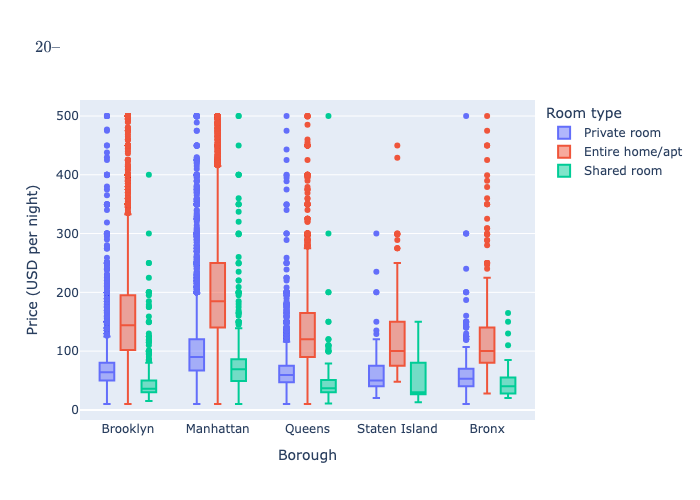

In [15]:
fig = px.box(
    airbnb_clean,
    x="neighbourhood_group",
    y="price",
    color="room_type",
    points="outliers",
    title="Airbnb Prices by Borough and Room Type (Filtered to $20–$500/night)",
    labels={
        "neighbourhood_group": "Borough",
        "price": "Price (USD per night)",
        "room_type": "Room type",
    },
)


fig.show()

fig.write_image("fig1.png")
from IPython.display import Image

Image(filename="fig1.png")


**Discussion**

From the boxplot and summary statistics:

- Across all boroughs, the median price of an entire home/apt is clearly higher than that of private rooms, which in turn are higher than shared rooms, confirming the second part of my hypothesis about room types.
- Manhattan entire homes/apartments are the most expensive segment in the city, with their median price above Brooklyn and Queens.
- The Bronx and Staten Island generally have the lowest prices, especially for private and shared rooms.

Overall, the data supports my hypothesis that Manhattan is the most expensive borough and that entire homes are the priciest room type within each borough.


### Step 3 – Defining “value for money”

The second part of my research question asks:

> Which neighborhoods offer the best “value for money,” defined as listings that are relatively cheap but still attract many reviews?

The dataset does not include review *scores*, but it does include:
- `price`: nightly price,
- `reviews_per_month`: how frequently guests leave reviews,

so I treat review activity as a proxy for demand and guest satisfaction (people tend to review stays they care about).  

To operationalize “value for money” at the neighborhood level, I:

1. Restrict to listings with prices between $20 and $500 (removing extreme outliers and ultra-budget anomalies).
2. Aggregate by `neighbourhood_group` and `neighbourhood`:
   - `listings` – number of listings in the neighborhood,
   - `median_price` – typical nightly price,
   - `mean_reviews_per_month` – typical review activity,
   - plus some other summary statistics.
3. Keep only neighborhoods with at least 40 listings to avoid unstable estimates.
4. Standardize both:
   - `median_price` (z-score, higher = more expensive),
   - `mean_reviews_per_month` (z-score, higher = more review activity),
5. Compute a value score:

\[
\text{value\_score} = z(\text{reviews\_per\_month}) - z(\text{median\_price})
\]

A high value_score means:
- the neighborhood has unusually high review activity *and*  
- unusually low prices compared to other neighborhoods.


In [8]:
value_df = airbnb_clean[
    (airbnb_clean["price"] >= 20) & (airbnb_clean["price"] <= 500)
].copy()


neigh_stats = (
    value_df.groupby(["neighbourhood_group", "neighbourhood"])
    .agg(
        listings=("id", "count"),
        median_price=("price", "median"),
        median_reviews_per_month=("reviews_per_month", "median"),
        mean_reviews_per_month=("reviews_per_month", "mean"),
        total_reviews=("number_of_reviews", "sum"),
    )
    .reset_index()
)


neigh_stats_big = neigh_stats[neigh_stats["listings"] >= 40].copy()


neigh_stats_big["z_price"] = (
    neigh_stats_big["median_price"] - neigh_stats_big["median_price"].mean()
) / neigh_stats_big["median_price"].std()
neigh_stats_big["z_reviews"] = (
    neigh_stats_big["mean_reviews_per_month"]
    - neigh_stats_big["mean_reviews_per_month"].mean()
) / neigh_stats_big["mean_reviews_per_month"].std()


neigh_stats_big["value_score"] = (
    neigh_stats_big["z_reviews"] - neigh_stats_big["z_price"]
)

neigh_stats_big.head()


,neighbourhood_group,neighbourhood,listings,median_price,median_reviews_per_month,mean_reviews_per_month,total_reviews,z_price,z_reviews,value_score
0,Bronx,Allerton,42,66.5,1.135,1.615714,1803,-0.827133,0.475107,1.302240
9,Bronx,Concourse,50,81.0,0.995,1.472000,1643,-0.523356,0.257558,0.780914
15,Bronx,Fordham,63,60.0,0.790,1.146825,956,-0.963310,-0.234677,0.728632
18,Bronx,Kingsbridge,70,70.0,0.460,1.256857,1435,-0.753808,-0.068116,0.685692
19,Bronx,Longwood,61,75.0,0.850,1.447705,1653,-0.649057,0.220782,0.869838


### Step 4  Which neighborhoods offer the best “value for money”?

Using the value_score defined above, I now rank neighborhoods from best to worst “value for money.”


In [9]:
# Top 10 best value neighborhoods
top_value = neigh_stats_big.sort_values("value_score", ascending=False).head(10)

top_value


,neighbourhood_group,neighbourhood,listings,median_price,median_reviews_per_month,mean_reviews_per_month,total_reviews,z_price,z_reviews,value_score
141,Queens,East Elmhurst,183,60.0,3.860,4.499180,15096,-0.963310,4.839978,5.803287
172,Queens,Springfield Gardens,85,80.0,2.530,4.193176,5873,-0.544306,4.376762,4.921068
171,Queens,South Ozone Park,40,69.0,1.650,3.019750,1947,-0.774758,2.600478,3.375236
153,Queens,Jamaica,227,70.0,1.650,2.641938,9819,-0.753808,2.028562,2.782370
165,Queens,Queens Village,60,75.0,2.180,2.684000,2147,-0.649057,2.092233,2.741290
173,Queens,St. Albans,75,60.0,1.650,2.293333,2582,-0.963310,1.500859,2.464168
170,Queens,Rosedale,59,65.0,1.340,2.316949,1673,-0.858559,1.536607,2.395166
167,Queens,Richmond Hill,94,65.0,1.355,2.284362,3230,-0.858559,1.487278,2.345836
138,Queens,Corona,64,40.0,1.130,1.849844,1806,-1.382313,0.829523,2.211836
214,Staten Island,Tompkinsville,42,62.5,1.885,2.107857,2400,-0.910934,1.220092,2.131027


In [10]:
# Bottom 10 (worst value – expensive but relatively few reviews)
bottom_value = neigh_stats_big.sort_values("value_score", ascending=True).head(10)

bottom_value


,neighbourhood_group,neighbourhood,listings,median_price,median_reviews_per_month,mean_reviews_per_month,total_reviews,z_price,z_reviews,value_score
121,Manhattan,Tribeca,146,269.0,0.09,0.525137,1362,3.415279,-1.175763,-4.591043
115,Manhattan,NoHo,73,245.0,0.35,0.592329,911,2.912475,-1.074051,-3.986526
102,Manhattan,Flatiron District,69,218.0,0.22,0.910000,1071,2.346820,-0.593174,-2.939994
95,Manhattan,Battery Park City,65,175.0,0.03,0.373692,578,1.445962,-1.405014,-2.850976
126,Manhattan,West Village,720,200.0,0.29,0.749986,14249,1.969717,-0.835396,-2.805113
114,Manhattan,Murray Hill,466,186.0,0.09,0.592296,4315,1.676414,-1.074101,-2.750514
98,Manhattan,Civic Center,50,167.0,0.09,0.378800,595,1.278360,-1.397282,-2.675642
104,Manhattan,Greenwich Village,374,190.5,0.25,0.722326,6224,1.770690,-0.877266,-2.647956
112,Manhattan,Midtown,1382,199.0,0.13,0.858408,18616,1.948766,-0.671271,-2.620038
101,Manhattan,Financial District,718,200.0,0.32,1.014916,6804,1.969717,-0.434356,-2.404072


To make the “best value” places more visible, I plot the top 10 neighborhoods and their value scores.


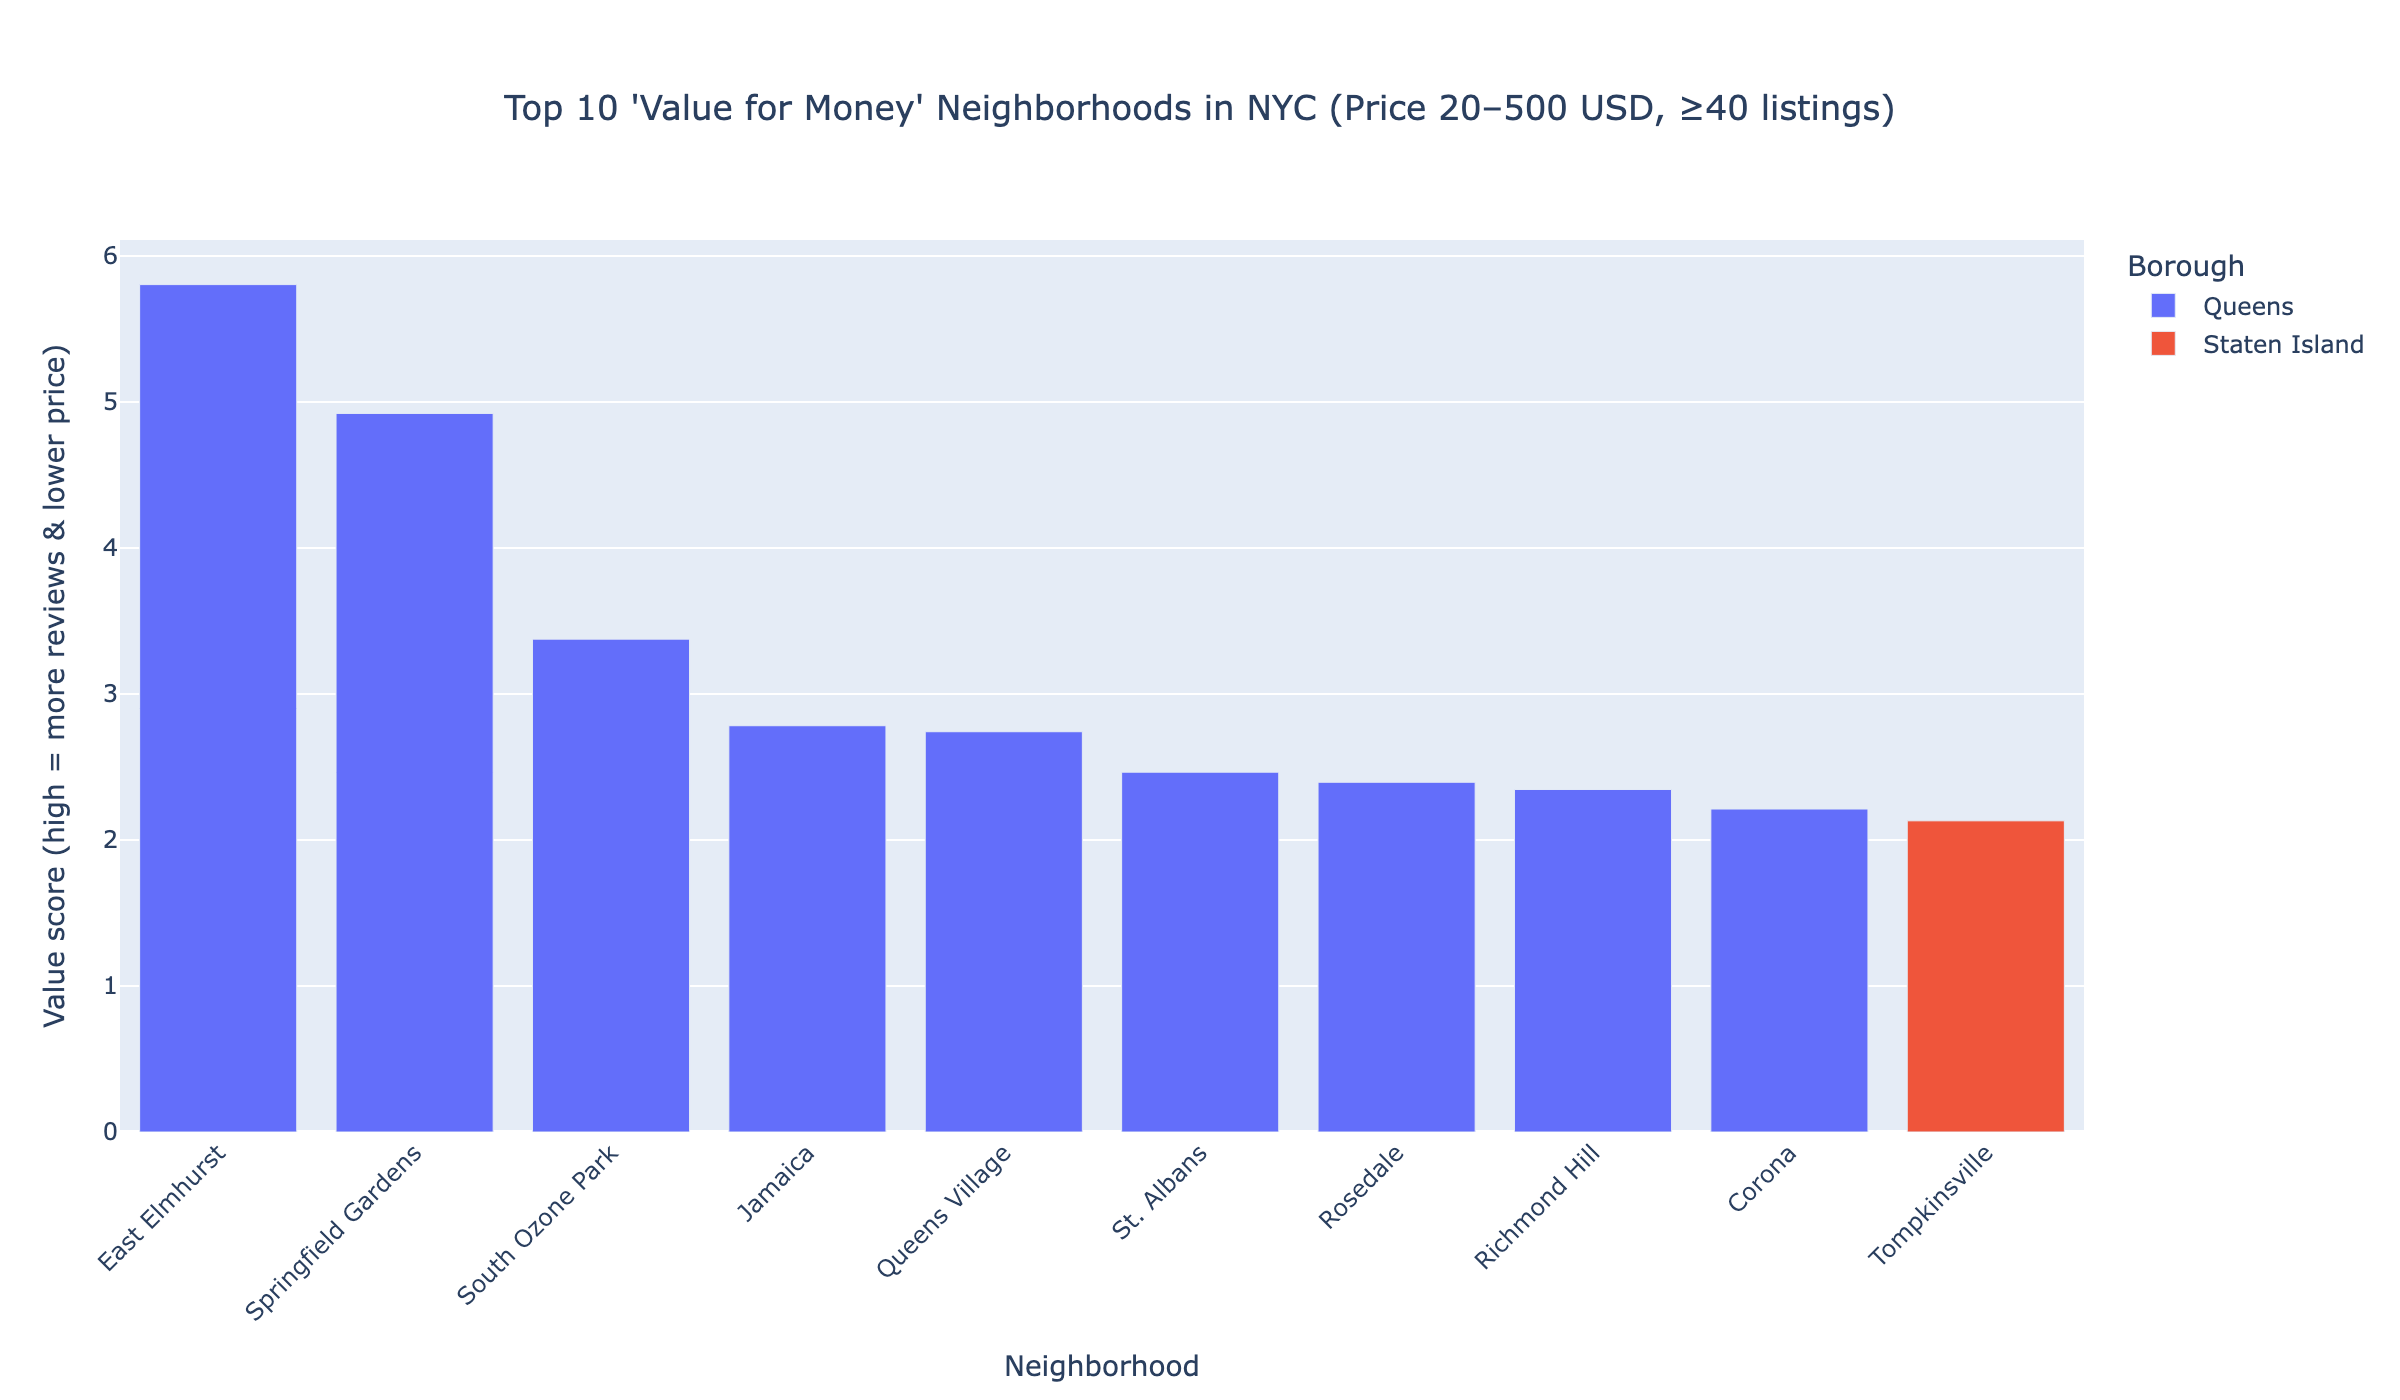

In [ ]:
fig = px.bar(
    top_value,
    x="neighbourhood",
    y="value_score",
    color="neighbourhood_group",
    title="Top 10 'Value for Money' Neighborhoods in NYC (Price 20–500 USD, ≥40 listings)",
    labels={
        "neighbourhood": "Neighborhood",
        "value_score": "Value score (high = more reviews & lower price)",
        "neighbourhood_group": "Borough",
    },
)


fig.update_layout(
    width=1000,
    height=600,
    margin=dict(l=60, r=60, t=120, b=120),
    xaxis_tickangle=-45,
    title_x=0.5,
)

fig.write_image("top10_value.png", width=1200, height=700, scale=2)

from IPython.display import Image

Image("top10_value.png")


For an additional perspective, I can also plot median price vs. mean reviews per month at the neighborhood level and highlight the best-value places.


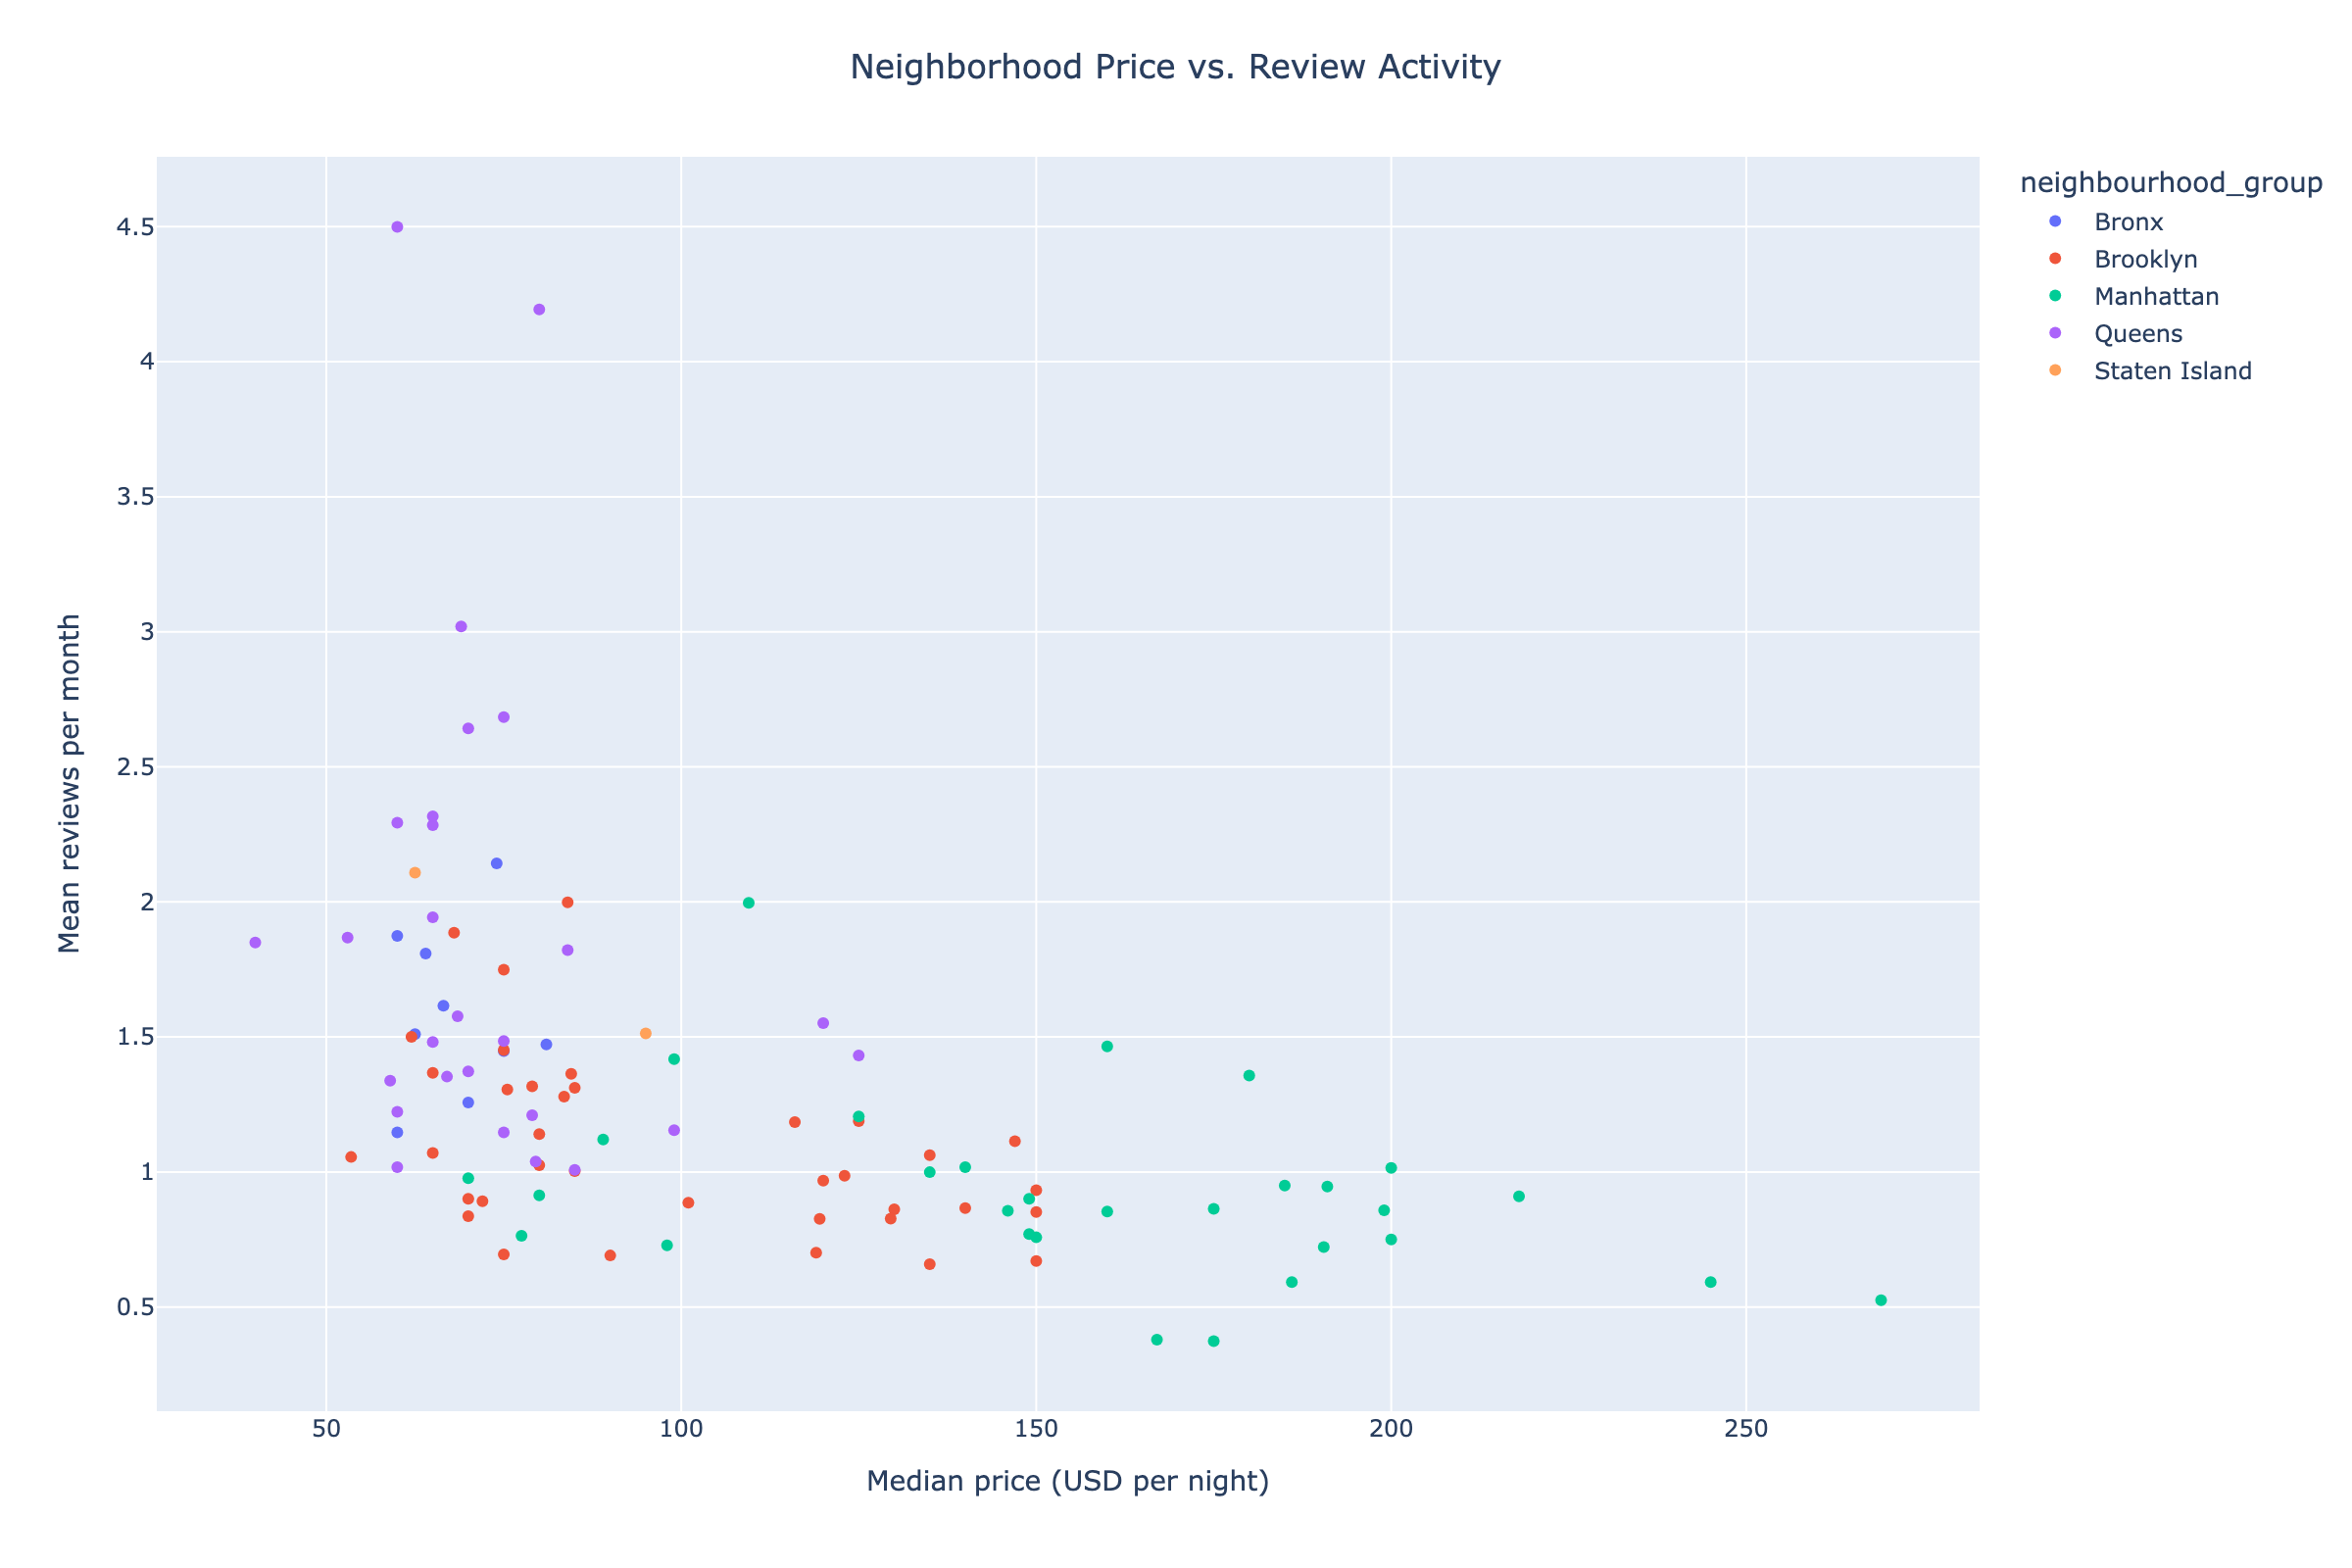

In [ ]:
fig = px.scatter(
    neigh_stats_big,
    x="median_price",
    y="mean_reviews_per_month",
    color="neighbourhood_group",
    hover_name="neighbourhood",
    title="Neighborhood Price vs. Review Activity",
    labels={
        "median_price": "Median price (USD per night)",
        "mean_reviews_per_month": "Mean reviews per month",
    },
)


fig.update_layout(margin=dict(l=80, r=160, t=80, b=80), title_x=0.5)


fig.write_image("scatter_value.png", width=1200, height=800, scale=2)

from IPython.display import Image

Image("scatter_value.png", width=800)


**Interpreting the results**


- The **top value-for-money neighborhoods** (highest value_score) are mostly located in Queens, such as *East Elmhurst*, *Springfield Gardens*, *South Ozone Park*, *Jamaica*, and *Queens Village*.  
  These areas combine:
  - relatively low median prices (often around \$60–80 per night),  
  - high review activity, suggesting that guests frequently book and review stays there.

On the other hand, neighborhoods with the lowest value scores (worst value for money) are mostly in Manhattan, including *Tribeca*, *NoHo*, *Flatiron District*, *Battery Park City*, *West Village*, and *Midtown*.  
These places have:

- very high median prices,  
- only moderate review activity,  

so they are expensive without providing proportionally higher “engagement” from guests.

Overall, this evidence supports my hypothesis that Queens and Staten Island contain many of the city’s best “value for money” neighborhoods, while some central Manhattan neighborhoods are relatively overpriced given their review activity.


### Step 5 – Conclusions

Bringing both parts of the analysis together:

1. **Price differences across boroughs and room types**

   - The dataset confirms that Manhattan is the most expensive borough, with the highest median nightly prices.
   - Brooklyn follows, while Queens, Staten Island, and the Bronx are substantially cheaper.
   - Across all boroughs, entire homes/apartments are the most expensive room type, then private rooms, then shared rooms, clearly confirming my hypothesis about room types.

2. **Best “value for money” neighborhoods**

   - By combining affordability (low median price) and popularity (high review activity) into a standardized value_score I identify several neighborhoods,especially in Queens,that provide strong value for money.
   - These neighborhoods offer significantly cheaper prices than central Manhattan while still attracting frequent reviews, meaning guests continue to choose and engage with these listings.
   - In contrast, some affluent Manhattan neighborhoods appear to be pricey without proportionally higher review activity, giving them low value scores.

From a public policy or urban planning perspective, this analysis highlights the role of outer-borough neighborhoods in making New York City more accessible to visitors with smaller budgets.  
At the same time, it suggests that highly central, prestigious neighborhoods may be capturing a “branding premium” rather than offering objectively better value based on price and review activity alone.

## Limitations and Extensions

- Review counts proxy visitor demand but may not reflect quality.
- The dataset is cross-sectional and may not capture seasonal variation or temporal shocks.
- Additional features such as distance to transit and host characteristics could improve explanatory depth.

Future analysis may incorporate regression modeling to predict price drivers or cluster analysis to classify neighborhood profiles.
